#### CSML1020 Course Project - New Plant Diseases Dectection
#### Authors (Group 3): Paul Doucet, Jerry Khidaroo

#### Initilization

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

In [3]:
# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

In [6]:
import tensorflow as tf


In [7]:
# Use this to enable GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for physical_device in physical_devices:
    tf.config.experimental.set_memory_growth(physical_device, True)

In [8]:
# # Use this to disable GPU
# tf.config.set_visible_devices([], 'GPU')

In [9]:
from keras.applications.vgg16 import VGG16
import keras
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import SGD
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


#### Model and Benchmarking Function Definitions

In [13]:
def get_model(base_model):
    #base_model=VGG16(include_top=False,input_shape=(224,224,3))
    base_model.trainable=False

    classifier=keras.models.Sequential()
    classifier.add(base_model)
    classifier.add(Flatten())
    classifier.add(Dense(38,activation='softmax'))
    
    classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [14]:
def Save_Benchmark(descr, metric, reset_rb, init_rb):
    global rows_benchmarks
    global df_benchmarks
    if (init_rb):
        rows_benchmarks = []
    else:
        if (reset_rb):
            rows_benchmarks = []

        rows_benchmarks.append([descr, metric])
        df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Pre-Prosessing Steps", "Validation Accuracy"])

In [15]:
def Save_Model_Benchmark(descr, history, reset_rb, init_rb):
    global rows_model_benchmarks
    global df_model_benchmarks
    if (init_rb):
        rows_model_benchmarks = []
    else:
        if (reset_rb):
            rows_model_benchmarks = []

        rows_model_benchmarks.append([descr, history.history['accuracy'][-1], history.history['loss'][-1], history.history['val_accuracy'][-1], 
            history.history['val_loss'][-1],])
        df_model_benchmarks = pd.DataFrame(rows_model_benchmarks, columns=["Classifier", "Accuracy", "Loss", "Validation Accuracy", "Validation Loss"])

In [16]:
def run_model(train_datagen, valid_set, batch_size, epochs):    
    training_set = train_datagen.flow_from_directory(dataDirTrain, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

    train_num = training_set.samples
    valid_num = valid_set.samples

    classifier = get_model()
    
    #fitting images to CNN
    history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=epochs, validation_steps=valid_num//batch_size)

    return history

In [17]:
# import matplotlib.pyplot as plt
# import seaborn as sns
sns.set()

def plot_history(model, history, axs, row):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    #accuracy plot   
    axs[row, 0].plot(epochs, acc, color='green', label='Training Accuracy')
    axs[row, 0].plot(epochs, val_acc, color='blue', label='Validation Accuracy')
    axs[row, 0].set_title(model + ' Training and Validation Accuracy')
    axs[row, 0].set_xlabel('Epoch')
    axs[row, 0].set_ylabel('Accuracy')
    
    #loss plot   
    axs[row, 1].plot(epochs, loss, color='pink', label='Training Loss')
    axs[row, 1].plot(epochs, val_loss, color='red', label='Validation Loss')
    axs[row, 1].set_title(model + ' Training and Validation Loss')
    axs[row, 1].set_xlabel('Epoch')
    axs[row, 1].set_ylabel('Accuracy')

#### Data Importing

In [4]:
# Image Data Folders
dataDirTrain = '../NewPlantDiseasesDatasetSample/train'
dataDirValidate = '../NewPlantDiseasesDatasetSample/valid'
dataDirTest = '../NewPlantDiseasesDatasetSample/test'

#### Data Pre-Processing Benchmarks

In [46]:
dg_descrs = ["rescale=1./255", 
    "rescale=1./255, shear_range=0.2", 
    "rescale=1./255, zoom_range=0.2", 
    "rescale=1./255, width_shift_range=0.2", 
    "rescale=1./255, width_shift_range=0.2",
    "rescale=1./255, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2",
    "rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, brightness_range=[0.2,1.0], zoom_range=[0.5,1.0]"
]

datagens = [
    ImageDataGenerator(rescale=1./255, fill_mode='nearest'),
    ImageDataGenerator(rescale=1./255, shear_range=0.2, fill_mode='nearest'),
    ImageDataGenerator(rescale=1./255, zoom_range=0.2, fill_mode='nearest'),
    ImageDataGenerator(rescale=1./255, width_shift_range=0.2, fill_mode='nearest'),
    ImageDataGenerator(rescale=1./255, height_shift_range=0.2, fill_mode='nearest'),
    ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest'),
    ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, brightness_range=[0.2,1.0], zoom_range=[0.5,1.0], fill_mode='nearest'),
    
    # ImageDataGenerator(rescale=1./255, width_shift_range=[-150,150], fill_mode='nearest'),
    # ImageDataGenerator(rescale=1./255, height_shift_range=0.5, fill_mode='nearest'),
    # ImageDataGenerator(rescale=1./255, horizontal_flip=True, fill_mode='nearest'),
    # ImageDataGenerator(rescale=1./255, vertical_flip=True, fill_mode='nearest'),
    # ImageDataGenerator(rescale=1./255, rotation_range=90, fill_mode='nearest'),
    # ImageDataGenerator(rescale=1./255, brightness_range=[0.2,1.0], fill_mode='nearest'),
    # ImageDataGenerator(rescale=1./255, zoom_range=[0.5,1.0], fill_mode='nearest')
]


# batch_size = 128
batch_size = 48
epochs = 3
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_set = valid_datagen.flow_from_directory(dataDirValidate, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
Save_Benchmark("", "", False, True)

for train_datagen, dg_descr in zip(datagens, dg_descrs):
    history = run_model(train_datagen, valid_set, batch_size, epochs)
    #history.history
    Save_Benchmark(dg_descr, history.history['val_accuracy'][2], False, False)
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    width_shift_range=0.2,
#                                    width_shift_range=0.2,)
df_benchmarks

Found 1900 images belonging to 38 classes.
Found 1900 images belonging to 38 classes.
Epoch 1/3
39/39 [==============================] - 16s 401ms/step - loss: 2.2084 - accuracy: 0.4579 - val_loss: 1.3819 - val_accuracy: 0.6784
Epoch 2/3
39/39 [==============================] - 16s 399ms/step - loss: 0.3372 - accuracy: 0.9158 - val_loss: 0.8835 - val_accuracy: 0.7646
Epoch 3/3
39/39 [==============================] - 16s 400ms/step - loss: 0.1054 - accuracy: 0.9897 - val_loss: 0.6529 - val_accuracy: 0.8083
Found 1900 images belonging to 38 classes.
Epoch 1/3
39/39 [==============================] - 27s 692ms/step - loss: 2.2236 - accuracy: 0.4359 - val_loss: 1.4048 - val_accuracy: 0.6720
Epoch 2/3
39/39 [==============================] - 26s 663ms/step - loss: 0.3375 - accuracy: 0.9176 - val_loss: 0.9115 - val_accuracy: 0.7300
Epoch 3/3
39/39 [==============================] - 25s 653ms/step - loss: 0.1613 - accuracy: 0.9622 - val_loss: 0.7173 - val_accuracy: 0.7446
Found 1900 images b

,Preprosessing Steps,accuracy
0,rescale=1./255,0.81
1,"rescale=1./255, shear_range=0.2",0.74
2,"rescale=1./255, zoom_range=0.2",0.75
3,"rescale=1./255, width_shift_range=0.2",0.74
4,"rescale=1./255, width_shift_range=0.2",0.77
5,"rescale=1./255, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2",0.71
6,"rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, brightness_range=[0.2,1.0], zoom_range=[0.5,1.0]",0.41


#### Load Train Image Data with Best Augmentation Filters

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

# batch_size = 128
batch_size = 48
training_set = train_datagen.flow_from_directory(dataDirTrain, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
valid_set = valid_datagen.flow_from_directory(dataDirValidate, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

train_num = training_set.samples
valid_num = valid_set.samples

Found 1900 images belonging to 38 classes.
Found 1900 images belonging to 38 classes.


In [11]:
# class_dict = training_set.class_indices
# print(class_dict)

In [12]:
# li = list(class_dict.keys())
# print(li)

#### Define Models to Investigate

In [18]:
from keras.applications import InceptionV3
from keras.applications.resnet50 import ResNet50

# Initialize Models
model_ids = ['VGG16', 'ResNet50', 'InceptionV3']
models = [
    get_model(VGG16(include_top=False,input_shape=(224,224,3))),
    get_model(ResNet50(include_top=False,input_shape=(224,224,3))),
    get_model(InceptionV3(include_top=False,input_shape=(224,224,3))),
]

#### Visualize Model Layers

Visualization of Layesr for:  VGG16  base Model with Transfer Learning



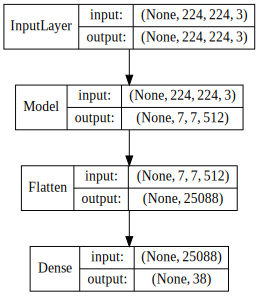


Visualization of Layesr for:  ResNet50  base Model with Transfer Learning



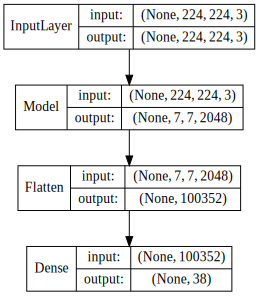


Visualization of Layesr for:  InceptionV3  base Model with Transfer Learning



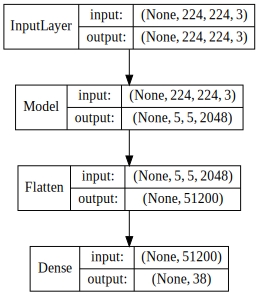

In [27]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Print Model Layers
for classifier, model_id in zip(models, model_ids):
    print('Visualization of Layers for: ', model_id, ' base Model with Transfer Learning')
    print('')
    display(SVG(model_to_dot(classifier, show_shapes=True, show_layer_names=False, dpi=70, rankdir='TB').create(prog='dot', format='svg')))
    print('')

#### Train Models

In [26]:
# Initialize function
Save_Model_Benchmark("", "", False, True)

# Train Models and Save Histories
histories = []
for classifier, model_id in zip(models, model_ids):    
    history = classifier.fit(training_set, steps_per_epoch=train_num//batch_size, validation_data=valid_set, epochs=3, validation_steps=valid_num//batch_size, )    
    Save_Model_Benchmark(model_id, history, False, False)
    histories.append(history)

df_model_benchmarks

Epoch 1/3
39/39 [==============================] - 27s 702ms/step - loss: 2.8972 - accuracy: 0.2856 - val_loss: 1.6241 - val_accuracy: 0.5235
Epoch 2/3
39/39 [==============================] - 27s 695ms/step - loss: 1.2328 - accuracy: 0.6544 - val_loss: 1.4505 - val_accuracy: 0.6301
Epoch 3/3
39/39 [==============================] - 27s 694ms/step - loss: 0.8170 - accuracy: 0.7586 - val_loss: 0.9159 - val_accuracy: 0.7165
Epoch 1/3
39/39 [==============================] - 30s 768ms/step - loss: 12.0481 - accuracy: 0.4379 - val_loss: 18.2285 - val_accuracy: 0.0272
Epoch 2/3
39/39 [==============================] - 29s 745ms/step - loss: 2.9387 - accuracy: 0.8056 - val_loss: 20.6389 - val_accuracy: 0.0340
Epoch 3/3
39/39 [==============================] - 28s 717ms/step - loss: 1.7139 - accuracy: 0.8720 - val_loss: 24.6171 - val_accuracy: 0.0324
Epoch 1/3
39/39 [==============================] - 27s 704ms/step - loss: 9.1070 - accuracy: 0.2554 - val_loss: 7.1728 - val_accuracy: 0.2719
Ep

,Classifier,Accuracy,Loss,Validation Accuracy,Validation Loss
0,VGG16,0.76,0.82,0.72,0.92
1,ResNet50,0.87,1.71,0.03,24.62
2,InceptionV3,0.73,1.35,0.35,5.15


#### Plot Model Training Results

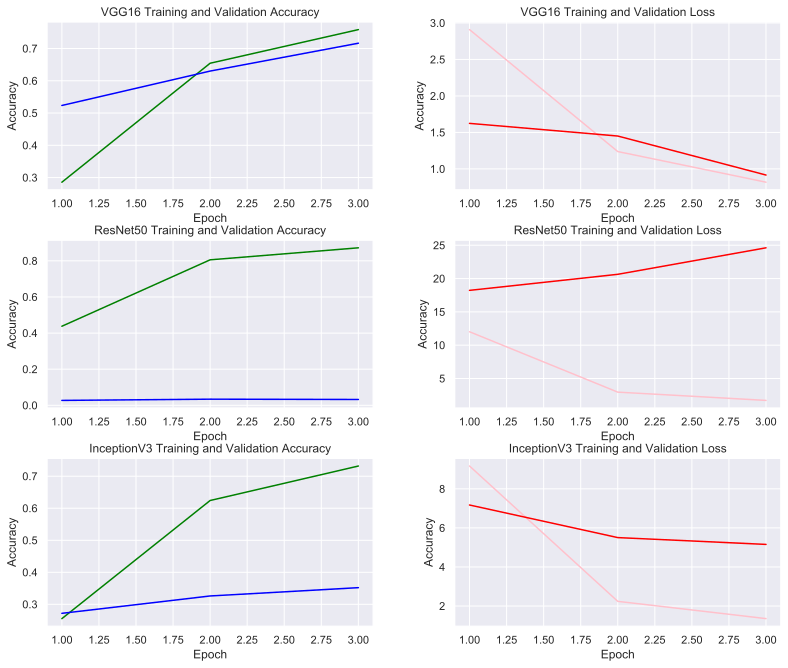

In [134]:
import matplotlib.gridspec as gridspec
import itertools

# Plot Accuacy and Loss for Model Histories
fig, axs = plt.subplots(3, 2, figsize=(12,10))

row = 0
for history, model_id in zip(histories, model_ids): 
    plot_history(model_id, history, axs, row)
    row = row + 1

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.3, wspace=0.25)
plt.show()

In [35]:
#fitting images to CNN
# history = classifier.fit(training_set,
#                          steps_per_epoch=train_num//batch_size,
#                          validation_data=valid_set,
#                          epochs=3,
#                          validation_steps=valid_num//batch_size,
#                          )

In [36]:
#Saving our model
# filepath="./Mymodel_sample.h5"
# classifier.save(filepath)

#### Perform Hyper-Parameter Tuning on Selected Model

In [28]:
def create_model(activation='softmax', learning_rate=0.01):
    base_model=VGG16(include_top=False,input_shape=(224,224,3))
    # base_model=VGG16(include_top=False,input_shape=(112,112,3))
    base_model.trainable=False

    classifier=keras.models.Sequential()
    classifier.add(base_model)
    classifier.add(Flatten())
    #classifier.add(Dense(38,activation='softmax'))
    classifier.add(Dense(38,activation=activation))

    opt = Adam(lr=learning_rate)
    
    #classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    classifier.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier

In [29]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from keras.optimizers import Adam
from keras import regularizers

# Create a KerasClassifier
model = KerasRegressor(build_fn = create_model, verbose = 0)

# Define the parameters to try out
params = {'activation': ["softmax", "tanh"],
          'batch_size': [16, 32, 48, 64], 
          'epochs': [3, 5, 10],
          'learning_rate': [0.01, 0.001, 0.0001]}

# Create a randomize search cv object passing in the parameters to try
random_search = RandomizedSearchCV(model,
                                   param_distributions = params,
                                   cv = KFold(10))

X_train, y_train = next(training_set)

random_search_results = random_search.fit(X_train, y_train)

# Print best score and parameters
print("Best Score: ", random_search_results.best_score_, "and Best Params: ", random_search_results.best_params_)

Best Score:  -3.851333498954773 and Best Params:  {'learning_rate': 0.0001, 'epochs': 3, 'batch_size': 32, 'activation': 'softmax'}


In [ ]:
#### Re-Run Selected Model 

In [29]:
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
# from keras.optimizers import Adam
# from keras import regularizers

# # Create a KerasClassifier
# model = KerasRegressor(build_fn = create_model, verbose = 0)

# # Define the parameters to try out
# params = {'activation': ["softmax", "tanh"],
#           'batch_size': [16, 32, 48], 
#           'epochs': [3, 5],
#           'learning_rate': [0.01, 0.001, 0.0001]}

# # Create a grid search cv object passing in the parameters to try
# random_search = GridSearchCV(model, params, cv = KFold(10))

# X_train, y_train = next(training_set)

# grid_search_results = random_search.fit(X_train, y_train)

# # Print best score and parameters
# print("Best Score: ", grid_search_results.best_score_, "and Best Params: ", grid_search_results.best_params_)

#### Inference

In [48]:
# # predicting an image
# from keras.preprocessing import image
# import numpy as np
# image_path = "../NewPlantDiseasesDataset/test/Tomato_Late_blight01.JPG"
# new_img = image.load_img(image_path, target_size=(224, 224))
# img = image.img_to_array(new_img)
# img = np.expand_dims(img, axis=0)
# img = img/255

# print("Following is our prediction:")
# prediction = classifier.predict(img)
# # decode the results into a list of tuples (class, description, probability)
# # (one such list for each sample in the batch)
# d = prediction.flatten()
# j = d.max()
# for index,item in enumerate(d):
#     if item == j:
#         class_name = li[index]

# #ploting image with predicted class name        
# plt.figure(figsize = (4,4))
# plt.imshow(new_img)
# plt.axis('off')
# plt.title(class_name)
# plt.show()